# AED

In [27]:
import pandas as pdimport numpy as npimport matplotlib.pyplot as pltdf = pd.read_csv("RH2M_days.csv", dtype={"date": str})df = df.set_index("date").sort_index()df.index = pd.to_datetime(df.index, format="%Y%m%d")print(df.head())print(df.tail())print(df.info())

                     no2_ug_m3
timestamp                     
2023-10-06 03:00:00     45.308
2023-10-06 04:00:00     64.108
2023-10-06 05:00:00     75.952
2023-10-06 06:00:00     80.464
2023-10-06 07:00:00     67.868
                     no2_ug_m3
timestamp                     
2023-11-17 03:00:00     29.704
2023-11-17 04:00:00     45.496
2023-11-17 05:00:00     51.888
2023-11-17 06:00:00     42.864
2023-11-17 07:00:00     34.968
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-10-06 03:00:00 to 2023-11-17 07:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   no2_ug_m3  1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB
None


In [28]:
print("Período de cobertura:", df.index.min().date(), "→", df.index.max().date())print("Total de pontos:", len(df))

Período de cobertura: 2023-10-06 → 2023-11-17
Total de pontos: 1000


In [29]:
print(df['RH2M_mean'].describe())

count    1000.000000
mean       44.988588
std        24.590277
min         2.632000
25%        22.372000
50%        43.428000
75%        65.612000
max       109.604000
Name: no2_ug_m3, dtype: float64


In [30]:
print("Nulos por coluna:\n", df.isna().sum())print("Duplicatas no índice:", df.index.duplicated().sum())

Nulos por coluna:
 no2_ug_m3    0
dtype: int64
Duplicatas no índice: 0


In [31]:
# Intervalos observadosintervalos = df.index.to_series().diff().dropna()print("Intervalos mais comuns:\n", intervalos.value_counts().head())# Construir grade diária completa e checar datas faltantesfull_range = pd.date_range(df.index.min(), df.index.max(), freq='D')missing_dates = full_range.difference(df.index)print("Datas faltantes:", list(missing_dates))# Versão reindexada (opcional) para análises que exigem regularidadedf_daily = df.reindex(full_range)df_daily.rename_axis('timestamp', inplace=True)# NÃO interpolar ainda (só para ver); se quiser visualizar com preenchimento:# df_filled = df_daily.interpolate(limit_direction='both')

Intervalos mais comuns:
 timestamp
0 days 01:00:00    991
0 days 02:00:00      6
0 days 05:00:00      1
0 days 04:00:00      1
Name: count, dtype: int64
Datas faltantes: []


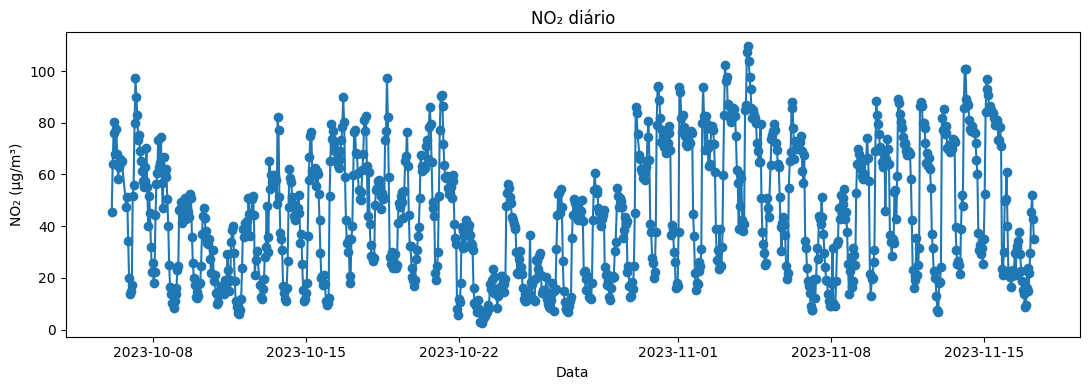

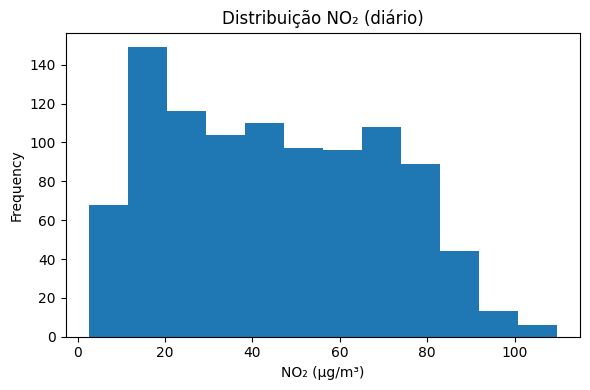

<Figure size 1000x400 with 0 Axes>

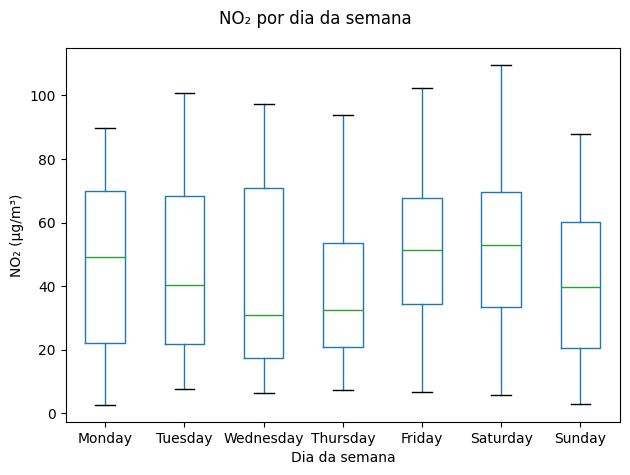

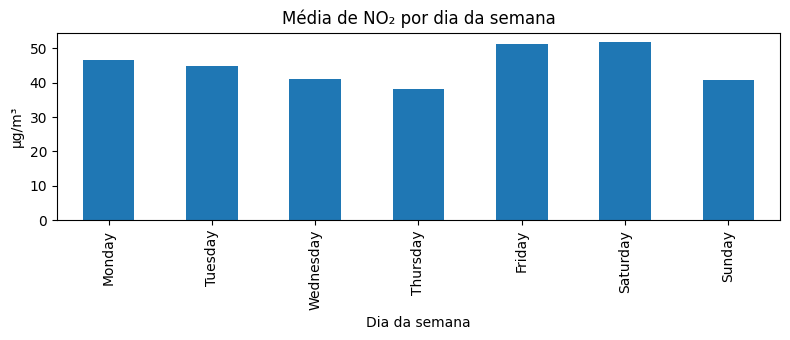

In [32]:
plt.figure(figsize=(11,4))plt.plot(df.index, df['RH2M_mean'], marker='o')plt.title('RH2M diário')plt.xlabel('Data'); plt.ylabel('RH2M (%)')plt.tight_layout(); plt.show()# Histogramaplt.figure(figsize=(6,4))df['RH2M_mean'].plot(kind='hist', bins=12, title='Distribuição RH2M (diário)')plt.xlabel('RH2M (%)')plt.tight_layout(); plt.show()# Boxplots por dia da semanaby_wd = df.copy()by_wd['weekday'] = by_wd.index.day_name()order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']by_wd['weekday'] = pd.Categorical(by_wd['weekday'], categories=order, ordered=True)plt.figure(figsize=(10,4))by_wd.boxplot(column='RH2M_mean', by='weekday', grid=False)plt.suptitle('RH2M por dia da semana'); plt.title('')plt.xlabel('Dia da semana'); plt.ylabel('RH2M (%)')plt.tight_layout(); plt.show()# Médias por dia da semana (barra)plt.figure(figsize=(8,3.5))by_wd.groupby('weekday')['RH2M_mean'].mean().plot(kind='bar')plt.title('Média de RH2M por dia da semana')plt.ylabel('%'); plt.xlabel('Dia da semana')plt.tight_layout(); plt.show()

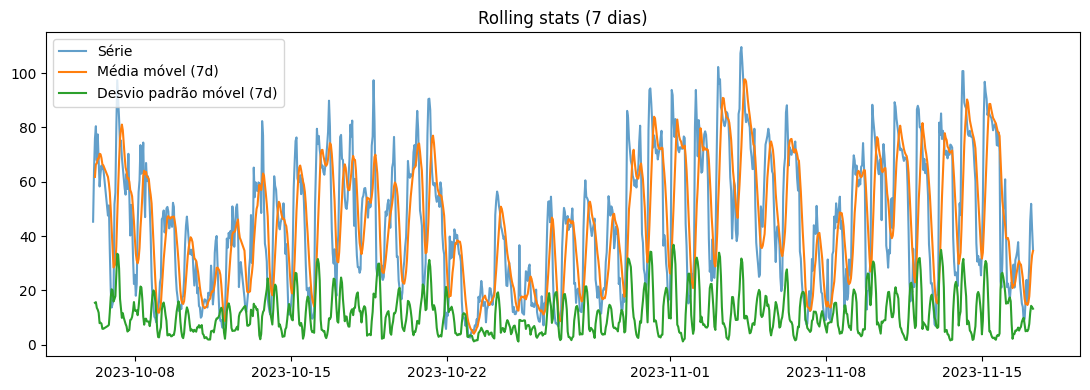

In [33]:
roll = df['RH2M_mean'].rolling(window=7, min_periods=3)plt.figure(figsize=(11,4))plt.plot(df.index, df['RH2M_mean'], label='Série', alpha=0.7)plt.plot(roll.mean(), label='Média móvel (7d)')plt.plot(roll.std(), label='Desvio padrão móvel (7d)')plt.legend(); plt.title('Rolling stats (7 dias)')plt.tight_layout(); plt.show()

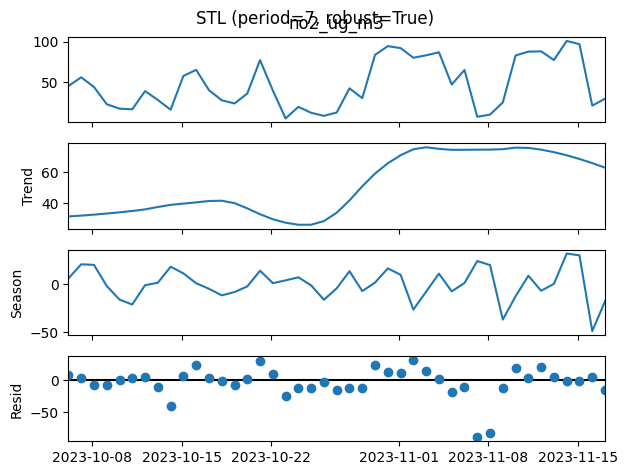

Força sazonal (aprox): 0.328


In [34]:
from statsmodels.tsa.seasonal import STL# Usar a série reindexada/preenchida para STL caso haja gapss = df_daily['RH2M_mean']s_interp = s.interpolate(limit_direction='both')stl = STL(s_interp, period=7, robust=True)res = stl.fit()res.plot()plt.suptitle('STL (period=7, robust=True)')plt.show()# Força sazonal aproximada (Hyndman): 1 - Var(remainder)/Var(seasonal+remainder)seasonal_var = np.var(res.seasonal)remainder_var = np.var(res.resid)seasonality_strength = 1 - (remainder_var / (seasonal_var + remainder_var))print(f"Força sazonal (aprox): {seasonality_strength:.3f}")

In [35]:
from statsmodels.tsa.stattools import adfuller, kpssy = df['RH2M_mean'].astype(float)# Dickey-Fuller (H0: não-estacionária)adf_stat, adf_p, *_ = adfuller(y.dropna(), autolag='AIC')print(f"ADF: stat={adf_stat:.3f} | p={adf_p:.4f}  -> p<0.05 sugere estacionária")# KPSS (H0: estacionária em nível). Pode falhar com amostras pequenas; usar try/except.try:    kpss_stat, kpss_p, *_ = kpss(y.dropna(), regression='c', nlags='auto')    print(f"KPSS: stat={kpss_stat:.3f} | p={kpss_p:.4f}  -> p<0.05 sugere não-estacionária")except Exception as e:    print("KPSS não pôde ser calculado:", e)

ADF: stat=-2.117 | p=0.2379  -> p<0.05 sugere estacionária
KPSS: stat=0.645 | p=0.0185  -> p<0.05 sugere não-estacionária


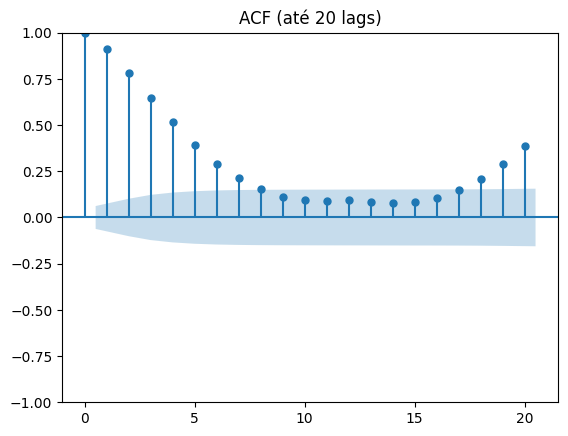

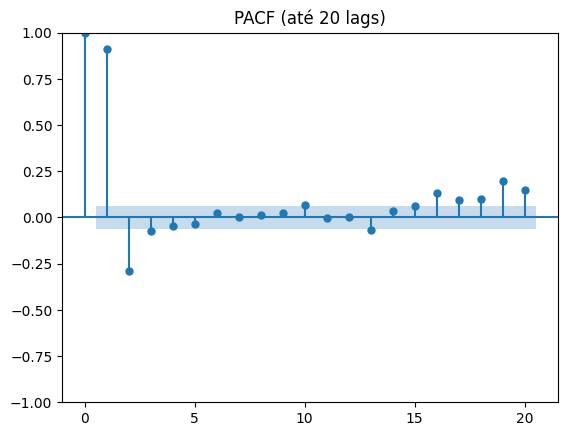

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacfplot_acf(y, lags=20)plt.title('ACF (até 20 lags)')plt.show()plot_pacf(y, lags=20, method='ywm')plt.title('PACF (até 20 lags)')plt.show()

In [37]:
# Z-score simplesz = (y - y.mean()) / y.std(ddof=0)outliers = y[np.abs(z) > 3]print("Outliers (|z|>3):")print(outliers)# Diferenças absolutas dia-a-dia (para possíveis quebras)diff1 = y.diff().abs()print("Top 5 maiores variações diárias:\n", diff1.sort_values(ascending=False).head())

Outliers (|z|>3):
Series([], Name: no2_ug_m3, dtype: float64)
Top 5 maiores variações diárias:
 timestamp
2023-11-13 02:00:00    57.528
2023-11-01 02:00:00    56.024
2023-11-12 02:00:00    54.896
2023-11-02 03:00:00    48.880
2023-11-15 20:00:00    47.564
Name: no2_ug_m3, dtype: float64


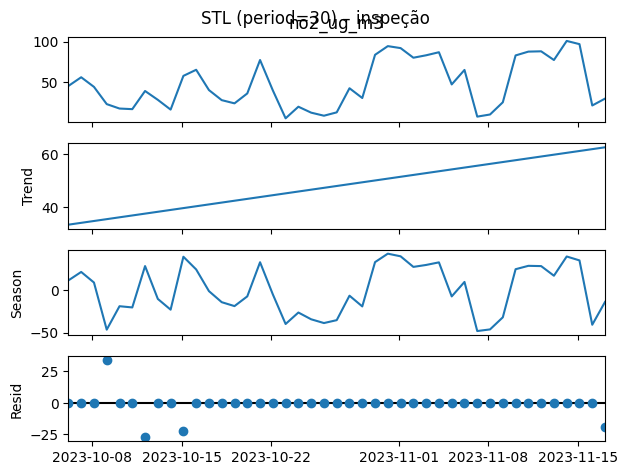

In [38]:
stl30 = STL(s_interp, period=30, robust=True).fit()stl30.plot()plt.suptitle('STL (period=30) – inspeção')plt.show()

In [45]:
import pandas as pdimport numpy as npimport matplotlib.pyplot as pltdf = pd.read_csv("RH2M_days.csv", dtype={"date": str})df = df.set_index("date").sort_index()df.index = pd.to_datetime(df.index, format="%Y%m%d")print("Cobertura:", df.index.min().date(), "→", df.index.max().date(), "| pontos:", len(df))print(df['RH2M_mean'].describe())print("Nulos:", df.isna().sum().to_dict(), "| Duplicatas no índice:", df.index.duplicated().sum())

Cobertura: 2023-10-06 → 2023-11-17 | pontos: 1000
count    1000.000000
mean       44.988588
std        24.590277
min         2.632000
25%        22.372000
50%        43.428000
75%        65.612000
max       109.604000
Name: no2_ug_m3, dtype: float64
Nulos: {'no2_ug_m3': 0} | Duplicatas no índice: 0


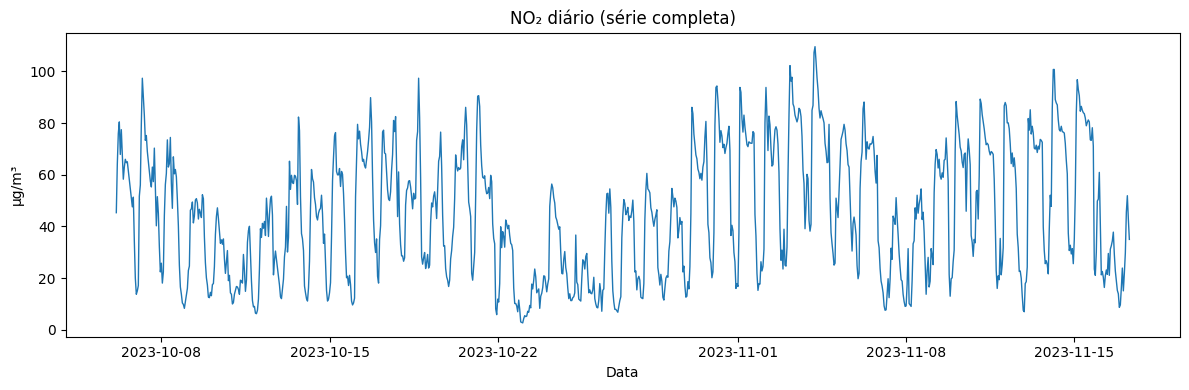

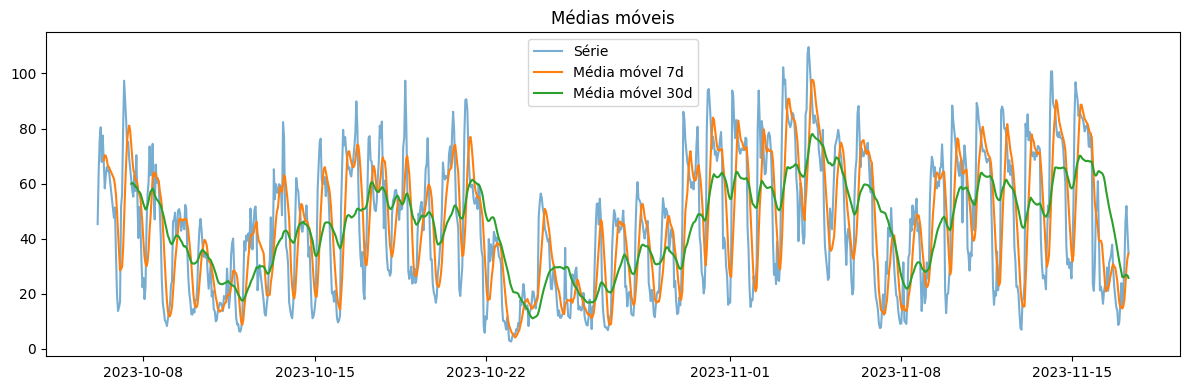

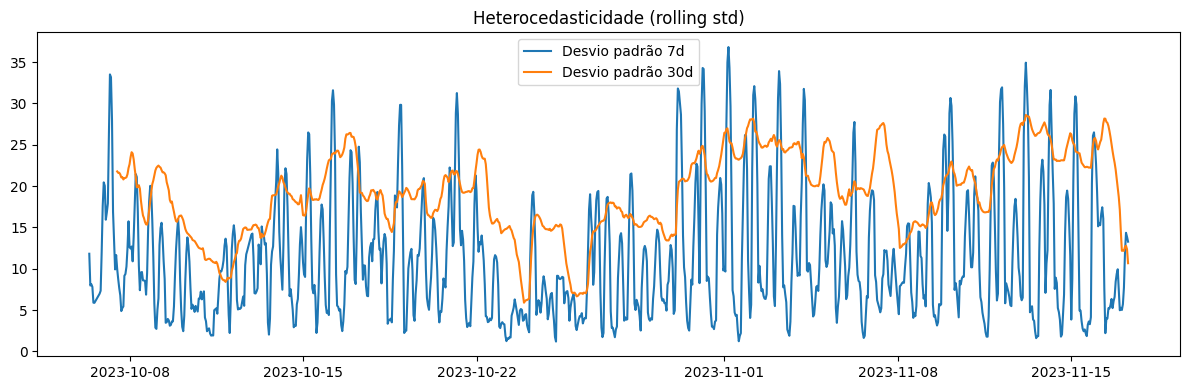

In [46]:
plt.figure(figsize=(12,4))plt.plot(df.index, df['RH2M_mean'], lw=1)plt.title("RH2M diário (série completa)")plt.xlabel("Data"); plt.ylabel("%")plt.tight_layout(); plt.show()# Rolling de 7 e 30 diasroll7 = df['RH2M_mean'].rolling(7)roll30 = df['RH2M_mean'].rolling(30)plt.figure(figsize=(12,4))plt.plot(df.index, df['RH2M_mean'], alpha=.6, label='Série')plt.plot(roll7.mean(), label='Média móvel 7d')plt.plot(roll30.mean(), label='Média móvel 30d')plt.legend(); plt.title("Médias móveis")plt.tight_layout(); plt.show()plt.figure(figsize=(12,4))plt.plot(roll7.std(), label='Desvio padrão 7d')plt.plot(roll30.std(), label='Desvio padrão 30d')plt.legend(); plt.title("Heterocedasticidade (rolling std)")plt.tight_layout(); plt.show()

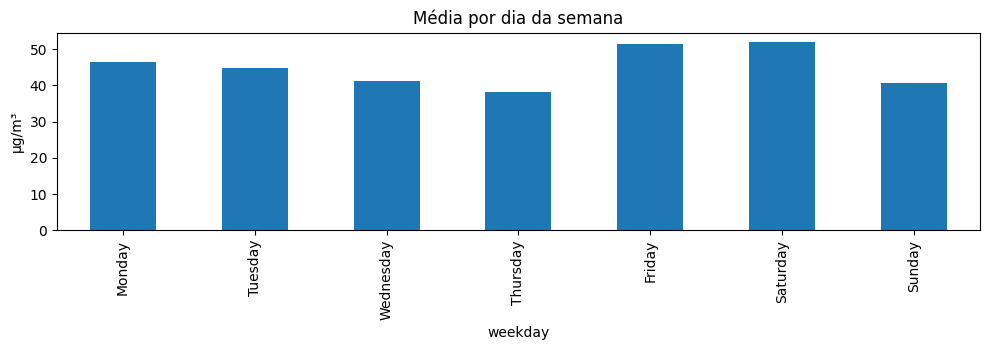

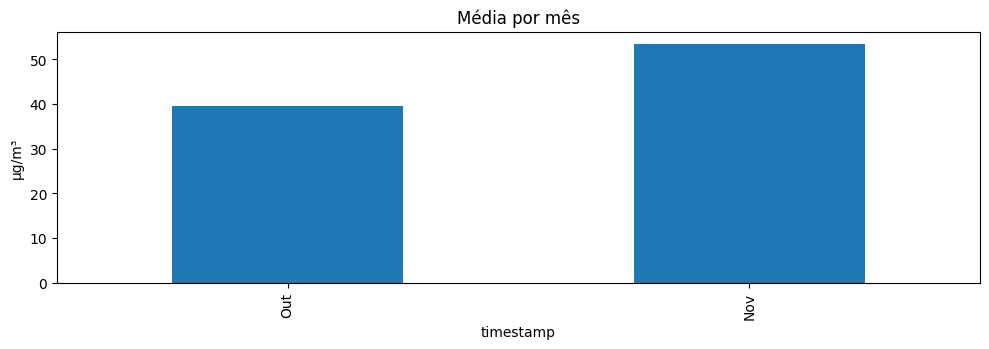

In [47]:
tmp = df.copy()tmp['weekday'] = tmp.index.day_name()tmp['month'] = tmp.index.month_name()order_wd = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']tmp['weekday'] = pd.Categorical(tmp['weekday'], categories=order_wd, ordered=True)plt.figure(figsize=(10,3.6))tmp.groupby('weekday')['RH2M_mean'].mean().plot(kind='bar')plt.title('Média por dia da semana'); plt.ylabel('%'); plt.tight_layout(); plt.show()plt.figure(figsize=(10,3.6))(tmp.groupby(tmp.index.month)['RH2M_mean'].mean() .rename(index={1:'Jan',2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez'}) .plot(kind='bar'))plt.title('Média por mês'); plt.ylabel('%'); plt.tight_layout(); plt.show()

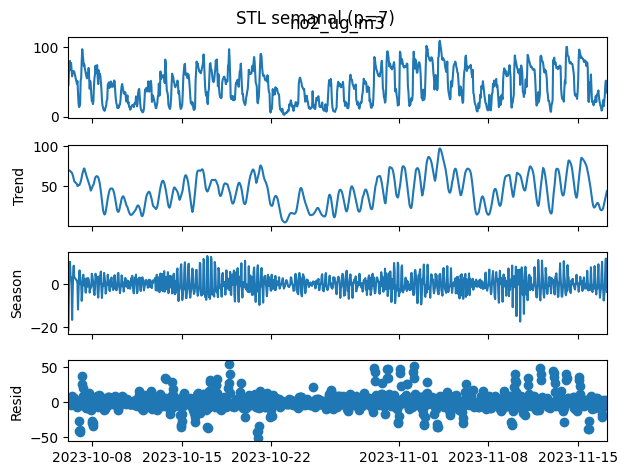

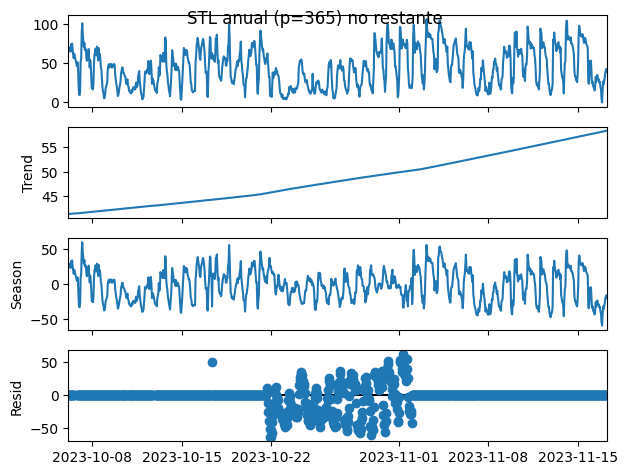

In [49]:
from statsmodels.tsa.seasonal import STLy = df['RH2M_mean'].astype(float)stl7 = STL(y, period=7, robust=True).fit()stl365 = STL(y - stl7.seasonal, period=365, robust=True).fit()  # remove semanal e decompõe anual no restantestl7.plot(); plt.suptitle('STL semanal (p=7)'); plt.show()stl365.plot(); plt.suptitle('STL anual (p=365) no restante'); plt.show()

# Treino

In [40]:
import pandas as pdimport numpy as npimport matplotlib.pyplot as pltfrom sklearn.ensemble import RandomForestRegressorfrom sklearn.preprocessing import OneHotEncoder, StandardScalerfrom sklearn.compose import ColumnTransformerfrom sklearn.pipeline import Pipelinefrom sklearn.metrics import mean_absolute_error, mean_squared_error# ======= Configs =======LAGS = 7         # lags diários que usaremosHORIZON = 3      # queremos prever 3 diasRANDOM_STATE = 42def load_daily_csv(path_or_str: str) -> pd.Series:    """Aceita caminho de arquivo ou string CSV; retorna a série diária ordenada."""    import io    if isinstance(path_or_str, str) and "\n" in path_or_str:        df = pd.read_csv(io.StringIO(path_or_str), dtype={"date": str})    else:        df = pd.read_csv(path_or_str, dtype={"date": str})    df = df.set_index("date").sort_index()    if df.index.tz is not None:        df.index = df.index.tz_localize(None)    s = df["RH2M_mean"].astype(float)    return sdef make_lag_frame(series: pd.Series, lags: int = LAGS) -> pd.DataFrame:    """Cria frame com alvo, lags e 'weekday' (0=Mon..6=Sun)."""    df = pd.DataFrame({"y": series})    for i in range(1, lags + 1):        df[f"lag_{i}"] = series.shift(i)    df["weekday"] = df.index.weekday  # 0-6    return df.dropna()  # remove as primeiras linhas sem lags

In [43]:
def forecast_next_n(series: pd.Series, n: int, pipe, lags: int = LAGS) -> pd.Series:    """    Faz previsão iterativa (multi-step) de n dias à frente usando o pipeline treinado.    Usa os últimos `lags` valores (observados + previstos).    """    # janela inicial com últimos lags observados    window = list(series.iloc[-lags:].values)    preds = []    dates = []    last_date = series.index[-1]    for step in range(1, n + 1):        next_date = last_date + pd.Timedelta(days=step)        weekday = next_date.weekday()        # monta o vetor de features: lag_1..lag_LAGS + weekday        row = {f"lag_{i}": window[-i] for i in range(1, lags + 1)}        row["weekday"] = weekday        X_row = pd.DataFrame([row], index=[next_date])        y_hat = float(pipe.predict(X_row)[0])        preds.append(y_hat)        dates.append(next_date)        # atualiza a janela com a previsão recém-gerada        window.append(y_hat)        window = window[-lags:]    return pd.Series(preds, index=pd.DatetimeIndex(dates), name="pred")# prever 3 dias à frente a partir do treino (out-of-sample)pred_3 = forecast_next_n(train_s, HORIZON, pipe, lags=LAGS)pred_3

2023-11-18 04:00:00    52.188173
2023-11-19 04:00:00    55.405480
2023-11-20 04:00:00    55.940653
Name: pred, dtype: float64

Avaliação vs. últimos 3 dias reais:
Seasonal Naive       -> MAE: 29.39 | RMSE: 30.32
Weekday Mean (3w)    -> MAE: 24.22 | RMSE: 25.43
Local Ridge          -> MAE: 21.47 | RMSE: 21.71
Ensemble             -> MAE: 26.22 | RMSE: 26.83


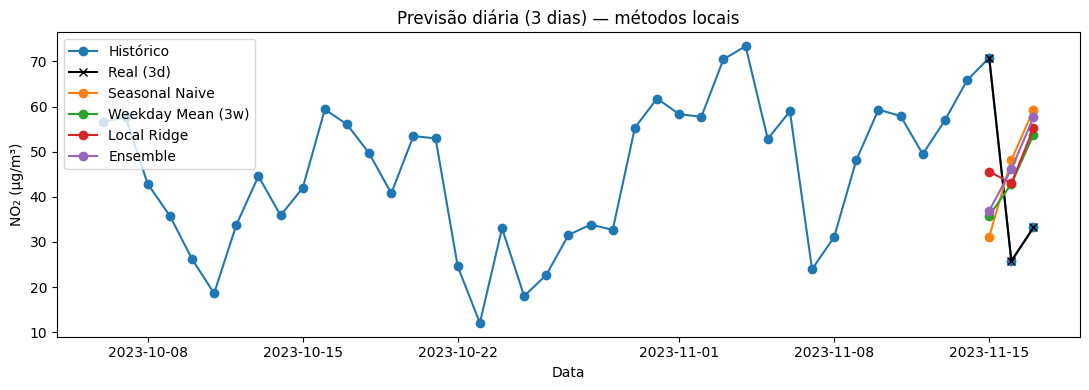

In [ ]:
import pandas as pdimport numpy as npimport matplotlib.pyplot as pltfrom sklearn.linear_model import Ridgefrom sklearn.preprocessing import StandardScalerfrom sklearn.pipeline import Pipelinefrom sklearn.metrics import mean_absolute_error, mean_squared_errorimport io# ===== Helpers =====def load_daily_csv(path_or_str: str) -> pd.Series:    if isinstance(path_or_str, str) and "\n" in path_or_str:        df = pd.read_csv(io.StringIO(path_or_str), dtype={"date": str})    else:        df = pd.read_csv(path_or_str, dtype={"date": str})    df = df.set_index("date").sort_index()    if df.index.tz is not None:        df.index = df.index.tz_localize(None)    return df["RH2M_mean"].astype(float)def seasonal_naive(s: pd.Series, h: int, m: int = 7) -> pd.Series:    """y_hat(t+h) = y(t+h-m). Requer pelo menos m pontos."""    if len(s) < m:        raise ValueError(f"Precisa de pelo menos {m} pontos para seasonal naive.")    idx = pd.date_range(s.index[-1] + pd.Timedelta(days=1), periods=h, freq="D")    # pega os últimos m valores e “alinha” com o horizonte    last_m = s.iloc[-m:].values    preds = []    for hstep in range(1, h+1):        preds.append(last_m[(hstep-1) % m])    return pd.Series(preds, index=idx, name="seasonal_naive")def seasonal_weekday_mean(s: pd.Series, h: int, weeks: int = 3) -> pd.Series:    """    Para cada dia futuro, usa a média dos mesmos dias da semana nas últimas `weeks` semanas.    Ex.: se for próxima 3ª feira, faz média das 3 últimas 3ªs-feiras.    """    idx = pd.date_range(s.index[-1] + pd.Timedelta(days=1), periods=h, freq="D")    preds = []    for dt in idx:        wd = dt.weekday()  # 0=Mon        # colete últimos 'weeks' valores com o mesmo weekday        candidates = s[s.index.weekday == wd].iloc[-weeks:]        if len(candidates) == 0:            # fallback: usa o último valor            preds.append(s.iloc[-1])        else:            preds.append(candidates.mean())    return pd.Series(preds, index=idx, name=f"weekday_mean_{weeks}w")def _make_lag_row(window_vals, weekday, lags: int):    row = {f"lag_{i}": window_vals[-i] for i in range(1, lags+1)}    # codificação do weekday como sen/cos para evitar one-hot com pouquíssimo dado    row["wd_sin"] = np.sin(2*np.pi*weekday/7)    row["wd_cos"] = np.cos(2*np.pi*weekday/7)    return rowdef local_ridge_forecast(s: pd.Series, h: int, lags: int = 7, window: int = 21, alpha: float = 1.0) -> pd.Series:    """    Regressão Ridge local: treina somente nos últimos `window` dias, com lags curtos.    Usa features: lag_1..lag_L + sen/cos do dia da semana.    Previsão iterativa (multi-step).    """    s_train = s.iloc[-window:].copy() if len(s) > window else s.copy()    # montar dataset tabular    rows = []    ys = []    for t in range(lags, len(s_train)):        weekday = s_train.index[t].weekday()        window_vals = s_train.values[:t]        row = _make_lag_row(s_train.values[:t], weekday, lags)        # corrigir: usar os valores reais defasados (mais simples)        row = {f"lag_{i}": s_train.values[t-i] for i in range(1, lags+1)}        row["wd_sin"] = np.sin(2*np.pi*weekday/7)        row["wd_cos"] = np.cos(2*np.pi*weekday/7)        rows.append(row)        ys.append(s_train.values[t])    X = pd.DataFrame(rows)    y = np.array(ys)    pipe = Pipeline([        ("scaler", StandardScaler()),        ("ridge", Ridge(alpha=alpha, random_state=0))    ])    pipe.fit(X, y)    # Previsão iterativa    window_vals = list(s.iloc[-lags:].values)  # semente    idx = pd.date_range(s.index[-1] + pd.Timedelta(days=1), periods=h, freq="D")    preds = []    for dt in idx:        weekday = dt.weekday()        row = {f"lag_{i}": window_vals[-i] for i in range(1, lags+1)}        row["wd_sin"] = np.sin(2*np.pi*weekday/7)        row["wd_cos"] = np.cos(2*np.pi*weekday/7)        Xr = pd.DataFrame([row])        y_hat = float(pipe.predict(Xr)[0])        preds.append(y_hat)        window_vals.append(y_hat)        window_vals = window_vals[-lags:]    return pd.Series(preds, index=idx, name="local_ridge")# ===== Carregar sua série =====s = load_daily_csv("RH2M_days.csv")H = 3  # horizonte# Split: últimos 3 dias como "teste"train_s = s.iloc[:-H]test_s  = s.iloc[-H:]# ===== Rodar previsores =====pred_sn   = seasonal_naive(train_s, H, m=7)pred_wkm  = seasonal_weekday_mean(train_s, H, weeks=3)pred_lr   = local_ridge_forecast(train_s, H, lags=7, window=21, alpha=0.8)# Ensemble simples (mais peso no sazonal ingênuo)pred_ens = (0.6*pred_sn + 0.4*pred_lr).rename("ensemble_0.6SN_0.4LR")# ===== Avaliar =====def eval_and_print(name, y_true, y_pred):    mae = mean_absolute_error(y_true, y_pred.reindex(y_true.index))    rmse = np.sqrt(mean_squared_error(y_true, y_pred.reindex(y_true.index)))    print(f"{name:20s} -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")print("Avaliação vs. últimos 3 dias reais:")eval_and_print("Seasonal Naive", test_s, pred_sn)eval_and_print("Weekday Mean (3w)", test_s, pred_wkm)eval_and_print("Local Ridge", test_s, pred_lr)eval_and_print("Ensemble", test_s, pred_ens)# ===== Plot =====plt.figure(figsize=(11,4))plt.plot(s.index, s.values, marker="o", label="Histórico")plt.plot(test_s.index, test_s.values, color="black", marker="x", label="Real (3d)")plt.plot(pred_sn.index,  pred_sn.values,  marker="o", label="Seasonal Naive")plt.plot(pred_wkm.index, pred_wkm.values, marker="o", label="Weekday Mean (3w)")plt.plot(pred_lr.index,  pred_lr.values,  marker="o", label="Local Ridge")plt.plot(pred_ens.index, pred_ens.values, marker="o", label="Ensemble")plt.title("Previsão diária (3 dias) — métodos locais")plt.xlabel("Data"); plt.ylabel("RH2M (%)")plt.legend(); plt.tight_layout(); plt.show()

EMA(α=0.5) -> MAE: 23.99 | RMSE: 25.95


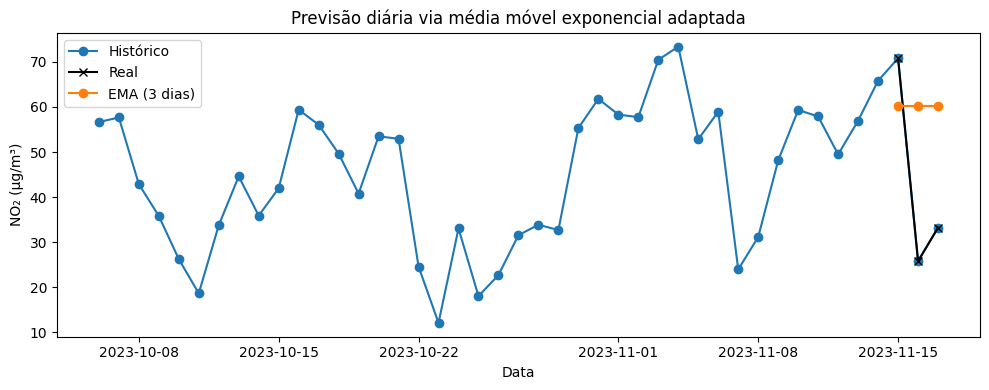

Ridge (lags+weekday+rm7) -> MAE: 18.46 | RMSE: 18.64
             Real  Ridge_pred
2023-11-15  70.81       53.80
2023-11-16  25.76       47.93
2023-11-17  33.21       49.39


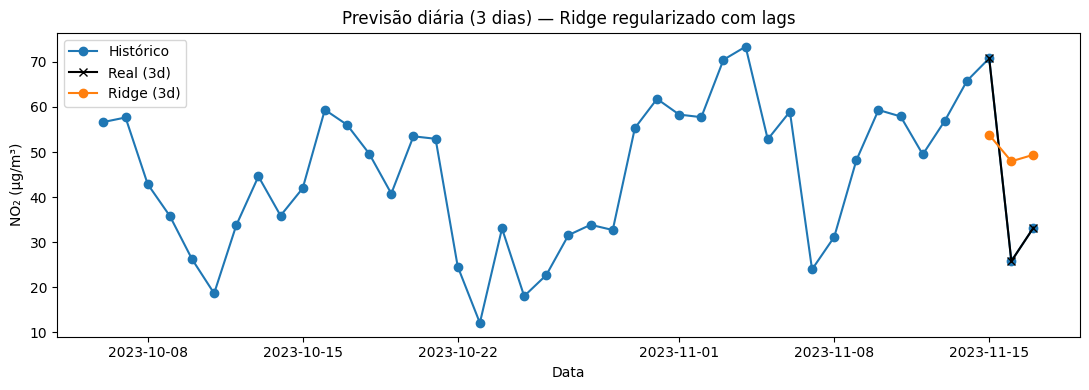

In [ ]:
import pandas as pdimport numpy as npimport matplotlib.pyplot as pltdef ema_forecast(series: pd.Series, alpha=0.5, horizon=3):    """Prevê próximos 'horizon' passos via média móvel exponencial."""    ema_last = series.ewm(alpha=alpha, adjust=False).mean().iloc[-1]    preds = [ema_last]  # primeira previsão = último EMA    for _ in range(1, horizon):        ema_last = alpha * preds[-1] + (1 - alpha) * ema_last        preds.append(ema_last)    idx = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=horizon, freq="D")    return pd.Series(preds, index=idx, name="EMA_pred")# Carregar seus dadosdf = pd.read_csv("RH2M_days.csv", dtype={"date": str}).set_index("date")df.index = pd.to_datetime(df.index, format="%Y%m%d")s = df["RH2M_mean"].astype(float)H = 3train_s = s.iloc[:-H]test_s = s.iloc[-H:]# Previsãopred_ema = ema_forecast(train_s, alpha=0.5, horizon=H)# Avaliarmae = np.mean(np.abs(pred_ema.values - test_s.values))rmse = np.sqrt(np.mean((pred_ema.values - test_s.values)**2))print(f"EMA(α=0.5) -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")plt.figure(figsize=(10,4))plt.plot(s.index, s.values, marker="o", label="Histórico")plt.plot(test_s.index, test_s.values, marker="x", color="black", label="Real")plt.plot(pred_ema.index, pred_ema.values, marker="o", label="EMA (3 dias)")plt.title("Previsão diária via média móvel exponencial adaptada")plt.xlabel("Data")plt.ylabel("RH2M (%)")plt.legend()plt.tight_layout()plt.show()import pandas as pdimport numpy as npimport io, warningswarnings.filterwarnings("ignore")from sklearn.linear_model import Ridgefrom sklearn.model_selection import TimeSeriesSplit, GridSearchCVfrom sklearn.preprocessing import OneHotEncoder, StandardScalerfrom sklearn.compose import ColumnTransformerfrom sklearn.pipeline import Pipelinefrom sklearn.metrics import mean_absolute_error, mean_squared_errorimport matplotlib.pyplot as plt# ===================== helpers =====================def load_daily_csv(path_or_str: str) -> pd.Series:    """Caminho de arquivo OU string CSV; retorna série diária ordenada."""    if isinstance(path_or_str, str) and "\n" in path_or_str:        df = pd.read_csv(io.StringIO(path_or_str), dtype={"date": str})    else:        df = pd.read_csv(path_or_str, dtype={"date": str})    df = df.set_index("date").sort_index()    if df.index.tz is not None:        df.index = df.index.tz_localize(None)    return df["RH2M_mean"].astype(float)LAGS = 7H = 3  # horizontedef make_supervised(series: pd.Series, lags=LAGS) -> pd.DataFrame:    """Cria dataframe com alvo y, lags 1..LAGS, rm7 (shifted) e weekday."""    df = pd.DataFrame({"y": series})    for i in range(1, lags+1):        df[f"lag_{i}"] = series.shift(i)    # média móvel de 7 dias, somente com passado (shift 1 p/ evitar vazamento)    df["rm7"] = series.shift(1).rolling(7, min_periods=1).mean()    df["weekday"] = series.index.weekday    return df.dropna()def fit_ridge_with_cv(df_sup: pd.DataFrame):    """Ajusta Ridge com GridSearchCV + TimeSeriesSplit."""    feature_cols = [c for c in df_sup.columns if c != "y"]    num_cols = [c for c in feature_cols if c not in ["weekday"]]    cat_cols = ["weekday"]    pre = ColumnTransformer(        transformers=[            ("num", StandardScaler(), num_cols),            ("cat", OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False), cat_cols),        ],        remainder="drop",    )    pipe = Pipeline([        ("pre", pre),        ("ridge", Ridge())    ])    # no dataset curto, 3 splits costuma funcionar    tscv = TimeSeriesSplit(n_splits=min(3, max(2, len(df_sup)//10)))    param_grid = {"ridge__alpha": [0.1, 0.3, 1.0, 3.0, 10.0]}    gs = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_squared_error")    X = df_sup.drop(columns=["y"])    y = df_sup["y"].values    gs.fit(X, y)    return gs.best_estimator_, feature_colsdef forecast_next_n_ridge(series: pd.Series, n: int, pipe, lags=LAGS) -> pd.Series:    """Previsão iterativa usando janelinha recente + rm7 dinâmica."""    history = list(series.values)        # histórico (cresce com previsões)    window  = list(series.iloc[-lags:].values)  # para lags    idx = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=n, freq="D")    preds = []    for dt in idx:        # construir features do próximo dia        feats = {f"lag_{i}": window[-i] for i in range(1, lags+1)}        # rm7 com base SOMENTE no passado disponível (observado+previsto)        rm7 = pd.Series(history).tail(7).mean()        feats["rm7"] = rm7        feats["weekday"] = dt.weekday()        X_row = pd.DataFrame([feats], index=[dt])        y_hat = float(pipe.predict(X_row)[0])        preds.append(y_hat)        history.append(y_hat)        window.append(y_hat)        window = window[-lags:]    return pd.Series(preds, index=idx, name="Ridge_pred")# ===================== treino/avaliação =====================# 1) carregar sua séries = load_daily_csv("RH2M_days.csv")# 2) separar treino/teste (3 últimos dias para teste)train_s, test_s = s.iloc[:-H], s.iloc[-H:]# 3) construir dataset supervisionado SÓ até a data de início do testedf_sup_full = make_supervised(s, lags=LAGS)split_date = test_s.index[0]df_sup_train = df_sup_full[df_sup_full.index < split_date]# 4) treinar com CV e prever 3 dias à frentebest_pipe, feat_cols = fit_ridge_with_cv(df_sup_train)pred_3 = forecast_next_n_ridge(train_s, H, best_pipe, lags=LAGS)# 5) métricas e plotmae = mean_absolute_error(test_s.values, pred_3.reindex(test_s.index).values)rmse = np.sqrt(mean_squared_error(test_s.values, pred_3.reindex(test_s.index).values))print(f"Ridge (lags+weekday+rm7) -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")print(pd.DataFrame({"Real": test_s, "Ridge_pred": pred_3}).round(2))plt.figure(figsize=(11,4))plt.plot(s.index, s.values, marker="o", label="Histórico")plt.plot(test_s.index, test_s.values, color="black", marker="x", label="Real (3d)")plt.plot(pred_3.index, pred_3.values, marker="o", label="Ridge (3d)")plt.title("Previsão diária (3 dias) — Ridge regularizado com lags")plt.xlabel("Data")plt.ylabel("RH2M (%)")plt.legend()plt.tight_layout()plt.show()

In [51]:
import pandas as pdimport numpy as npimport io, warningswarnings.filterwarnings("ignore")from sklearn.linear_model import Ridgefrom sklearn.model_selection import TimeSeriesSplit, GridSearchCVfrom sklearn.preprocessing import OneHotEncoder, StandardScalerfrom sklearn.compose import ColumnTransformerfrom sklearn.pipeline import Pipelinefrom sklearn.metrics import mean_absolute_error, mean_squared_errorimport matplotlib.pyplot as plt# ===================== helpers =====================def load_daily_csv(path_or_str: str) -> pd.Series:    """Caminho de arquivo OU string CSV; retorna série diária ordenada."""    if isinstance(path_or_str, str) and "\n" in path_or_str:        df = pd.read_csv(io.StringIO(path_or_str), dtype={"date": str})    else:        df = pd.read_csv(path_or_str, dtype={"date": str})    df = df.set_index("date").sort_index()    if df.index.tz is not None:        df.index = df.index.tz_localize(None)    return df["RH2M_mean"].astype(float)LAGS = 7H = 3  # horizontedef make_supervised(series: pd.Series, lags=LAGS) -> pd.DataFrame:    """Cria dataframe com alvo y, lags 1..LAGS, rm7 (shifted) e weekday."""    df = pd.DataFrame({"y": series})    for i in range(1, lags+1):        df[f"lag_{i}"] = series.shift(i)    # média móvel de 7 dias, somente com passado (shift 1 p/ evitar vazamento)    df["rm7"] = series.shift(1).rolling(7, min_periods=1).mean()    df["weekday"] = series.index.weekday    return df.dropna()def fit_ridge_with_cv(df_sup: pd.DataFrame):    """Ajusta Ridge com GridSearchCV + TimeSeriesSplit."""    feature_cols = [c for c in df_sup.columns if c != "y"]    num_cols = [c for c in feature_cols if c not in ["weekday"]]    cat_cols = ["weekday"]    pre = ColumnTransformer(        transformers=[            ("num", StandardScaler(), num_cols),            ("cat", OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False), cat_cols),        ],        remainder="drop",    )    pipe = Pipeline([        ("pre", pre),        ("ridge", Ridge())    ])    # no dataset curto, 3 splits costuma funcionar    tscv = TimeSeriesSplit(n_splits=min(3, max(2, len(df_sup)//10)))    param_grid = {"ridge__alpha": [0.1, 0.3, 1.0, 3.0, 10.0]}    gs = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_squared_error")    X = df_sup.drop(columns=["y"])    y = df_sup["y"].values    gs.fit(X, y)    return gs.best_estimator_, feature_colsdef forecast_next_n_ridge(series: pd.Series, n: int, pipe, lags=LAGS) -> pd.Series:    """Previsão iterativa usando janelinha recente + rm7 dinâmica."""    history = list(series.values)        # histórico (cresce com previsões)    window  = list(series.iloc[-lags:].values)  # para lags    idx = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=n, freq="D")    preds = []    for dt in idx:        # construir features do próximo dia        feats = {f"lag_{i}": window[-i] for i in range(1, lags+1)}        # rm7 com base SOMENTE no passado disponível (observado+previsto)        rm7 = pd.Series(history).tail(7).mean()        feats["rm7"] = rm7        feats["weekday"] = dt.weekday()        X_row = pd.DataFrame([feats], index=[dt])        y_hat = float(pipe.predict(X_row)[0])        preds.append(y_hat)        history.append(y_hat)        window.append(y_hat)        window = window[-lags:]    return pd.Series(preds, index=idx, name="Ridge_pred")# ===================== treino/avaliação =====================# 1) carregar sua série# s = load_daily_csv("RH2M_days.csv")# # 2) separar treino/teste (3 últimos dias para teste)# train_s, test_s = s.iloc[:-H], s.iloc[-H:]# # 3) construir dataset supervisionado SÓ até a data de início do teste# df_sup_full = make_supervised(s, lags=LAGS)# split_date = test_s.index[0]# df_sup_train = df_sup_full[df_sup_full.index < split_date]# # 4) treinar com CV e prever 3 dias à frente# best_pipe, feat_cols = fit_ridge_with_cv(df_sup_train)# pred_3 = forecast_next_n_ridge(train_s, H, best_pipe, lags=LAGS)# # 5) métricas e plot# mae = mean_absolute_error(test_s.values, pred_3.reindex(test_s.index).values)# rmse = np.sqrt(mean_squared_error(test_s.values, pred_3.reindex(test_s.index).values))# print(f"Ridge (lags+weekday+rm7) -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")# print(pd.DataFrame({"Real": test_s, "Ridge_pred": pred_3}).round(2))# plt.figure(figsize=(11,4))# plt.plot(s.index, s.values, marker="o", label="Histórico")# plt.plot(test_s.index, test_s.values, color="black", marker="x", label="Real (3d)")# plt.plot(pred_3.index, pred_3.values, marker="o", label="Ridge (3d)")# plt.title("Previsão diária (3 dias) — Ridge regularizado com lags")# plt.xlabel("Data"); plt.ylabel("RH2M (%)")# plt.legend(); plt.tight_layout(); plt.show()def prever_3_dias_ridge_csv(csv_input, lags=7) -> str:    """    Lê CSV (caminho ou string), treina Ridge com lags+weekday+rm7 usando todo o histórico,    e retorna 'v1,v2,v3' para os próximos 3 dias.    """    s = load_daily_csv(csv_input)    # supervisionado até o fim do histórico    df_sup = make_supervised(s, lags=lags)    pipe, _ = fit_ridge_with_cv(df_sup)    preds = forecast_next_n_ridge(s, 3, pipe, lags=lags)    return ",".join(f"{v:.2f}" for v in preds.values)# Exemplo:out = prever_3_dias_ridge_csv("RH2M_days.csv")print(out)  # "60.12,59.34,58.97"

42.20,37.88,34.03
